#### Project 4 - Image segmentation

We will first load the preliminaries

In [38]:
using PyPlot

function test_image(ver, m=50, noise=0)
    A = 0.8*ones(Float64, m, m)
    if ver == 1
        i = 1:m
        sc = m/100
        for c in [[50,60,20], [65,60,15], [35,30,15]]
            A = @. max(0.2, A - 0.6*Float64((i - sc*c[1])^2 + 
                    (i' - sc*c[2])^2 < (sc*c[3])^2))
        end
    elseif ver == 2
        is = [[25,35,25,35], [65,75,65,75], [65,75,45,50], [40,45,40,70]]
        for i in is
            i = round.(Int, i*m/100)
            A[i[1]:i[2], i[3]:i[4]] .= 0.3
        end
    else
        error("Unknown image version")
    end
    
    A += noise*randn(size(A))
    A = min.(max.(A, 0), 1)
end

test_image (generic function with 3 methods)

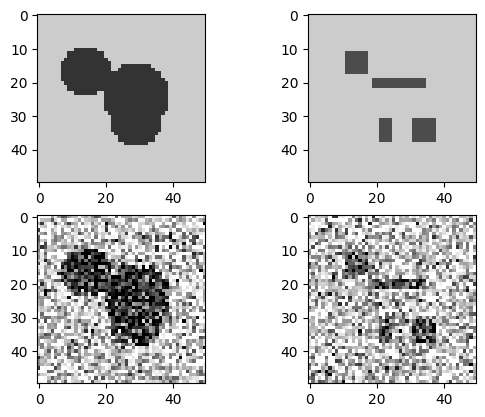

In [39]:
#This is a test case with no noise (top row) and with noise of magnitude 0.3 (bottom row).
count = 0
m = 50
for noise = [0, 0.3], ver = 1:2
    subplot(2,2,count+=1)
    A = test_image(ver, m, noise)
    imshow(A[:,:,[1,1,1]])
end

##### Level sets and contour plotting

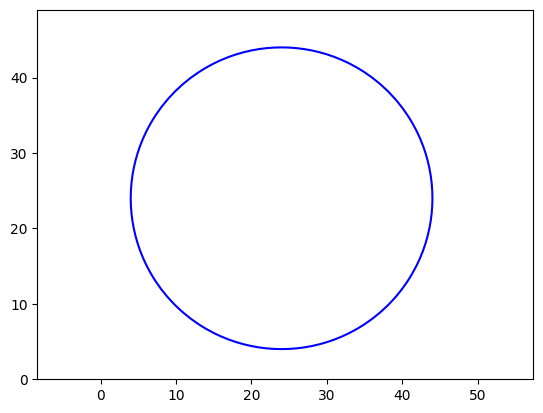

In [12]:
function initial_value(sz)
    m,n = sz
    Φ = [sqrt((i - m/2)^2 + (j - n/2)^2) - 0.4n for i = 1:m, j = 1:n]
end

# Test case
Φ = initial_value([50,50])
contour(Φ, [0.0], colors="b")
axis("equal");

#### Problem 1 - A type hierarchy for stencil operations

In [13]:
# We will first set up the stencil type
abstract type AbstractStencil end

#Define the mean filter subtype
struct AverageStencil <: AbstractStencil end

#Average of the 9 pixels
apply_to_3x3(s::AverageStencil, A33) = sum(A33) / length(A33)

function stencil_demo(s::AbstractStencil)
    count = 0
    plot_next(A) = subplot(1,4,count+=1), imshow(A[:,:,[1,1,1]])
    for noise = [0, 0.3]
        A = test_image(1, 50, noise)
        plot_next(A)
        plot_next(apply_stencil(s,A))
    end
end


stencil_demo (generic function with 1 method)

##### Problem 1(a)

In [14]:
function apply_stencil(s::AbstractStencil, A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        B[i,j] = apply_to_3x3(s,A[i-1:i+1, j-1:j+1])
    end
    return B
end

apply_stencil (generic function with 1 method)

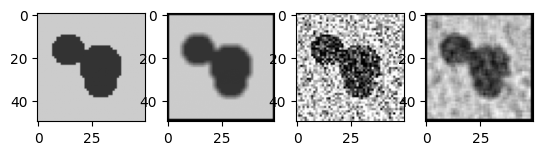

In [15]:
# Test code
stencil_demo(AverageStencil())

##### Problem 1(b)

In [26]:
#Define the mean filter subtype
struct EdgeStencil <: AbstractStencil end

apply_to_3x3(s::EdgeStencil, A33) = max(abs(A33[3,2] - A33[1,2]), abs(A33[2,3] - A33[2,1]))

function apply_stencil(s::EdgeStencil,A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        a = A[i-1:i+1, j-1:j+1]
        B[i,j] = apply_to_3x3(s,a)
    end
    return B
end

apply_stencil (generic function with 2 methods)

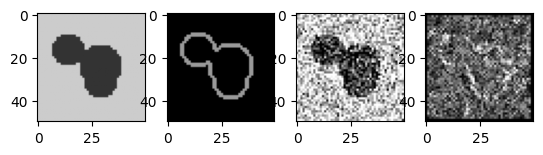

In [27]:
# Test code
stencil_demo(EdgeStencil())

#### Problem 2 - Utilities

##### Problem 2(a)

In [49]:
struct KappaStencil <: AbstractStencil end

function apply_to_3x3(s::KappaStencil,A33)
    xx = A33[3,2]-2*A33[2,2]+A33[1,2]
    yy = A33[2,3]-2*A33[2,2]+A33[2,1]
    xy = (A33[3,3]-A33[1,3]-A33[3,1]+A33[1,1])/4
    x = (A33[3,2]-A33[1,2])/2
    y = (A33[2,3]-A33[2,1])/2
    k0 = (xx*((y)^2)-2*x*y*xy+yy*((x)^2))/(((x^2)+(y^2))^(3/2)+10^(-6))
    kij = maximum([minimum([k0,5]),-5])
    return kij
end

function apply_stencil(s::KappaStencil,A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        a = A[i-1:i+1, j-1:j+1]
        B[i,j] = apply_to_3x3(s,a)
    end
    return B
end

apply_stencil (generic function with 3 methods)

##### Problem 2(b)

In [43]:
@. H(t) = 1/2*(1+2/π*atan(t))
@. δ(t) = 1/(π*(t^2+1))

δ (generic function with 1 method)

##### Problem 2(c)

In [29]:
function coefficient(Φ,A)
    c1 = (sum(A .* H.(Φ)))/sum(H.(Φ))
    c2 = (sum(A .* (1 .- H.(Φ))))/(sum(1 .- H.(Φ)))
    return c1,c2
end

coefficient (generic function with 1 method)

##### Problem 2(d)

In [47]:
function update(Φ,A)
    c1,c2 = coefficient(Φ,A)
    s = KappaStencil()
    m = 100 .*δ(Φ).*(0.2.*apply_stencil(s,Φ).-((A .- c1).^2)+(A.-c2).^2)
    return m
end

update (generic function with 1 method)

#### Problem 3 - Final Image Segmentation function

In [51]:
function image_segment(A; maxiter=100000)
    scale = size(A)
    Φ = initial_value([scale[1],scale[2]])
    n = 0
    D = update(Φ,A)
    while (maximum(abs.(D)) >= 2*10^(-2))&(n<=maxiter)
        Φ .+= D
        n += 1
        D = update(Φ,A)
    end
    return Φ
end

image_segment (generic function with 1 method)

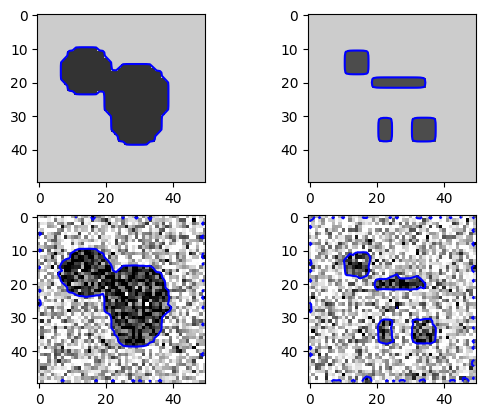

In [54]:
# Test code:
count = 0
for noise = [0, 0.3], ver = 1:2
    subplot(2,2,count+=1)
    A = test_image(ver, 50, noise)
    Φ = image_segment(A)
    imshow(A[:,:,[1,1,1]])
    contour(Φ, [0.0], colors="b")
end